In [1]:
import pandas as pd

In [2]:
dialect_df = pd.read_csv('data/clean_dataset.csv')

In [3]:
dialect_df

,id,dialect,tweet
0,1175358310087892992,IQ,لكن بالنهايه ينتفض يغير
1,1175416117793349632,IQ,يعني هذا محسوب علي البشر حيونه ووحشيه وتطلبون ...
2,1175450108898565888,IQ,مبين من كلامه خليجي
3,1175471073770573824,IQ,يسلملي مرورك وروحك الحلوه
4,1175496913145217024,IQ,وين هل الغيبه اخ محمد
...,...,...,...
458191,1019484980282580992,BH,مبسوطين منك اللي باسطانا
458192,1021083283709407232,BH,والله ماينده ابش يختي
458193,1017477537889431552,BH,شو عملنا لك حنا تهربي مننا احنا مساكين ليش بتع...
458194,1022430374696239232,BH,الله يبارك فيها وبالعافيه


# Check data imbalance

In [4]:
dialect_df['dialect'].value_counts()

EG    57636
PL    43742
KW    42109
LY    36499
QA    31069
JO    27921
LB    27617
SA    26831
AE    26296
BH    26292
OM    19116
SY    16242
DZ    16183
IQ    15497
SD    14434
MA    11539
YE     9927
TN     9246
Name: dialect, dtype: int64

<AxesSubplot:>

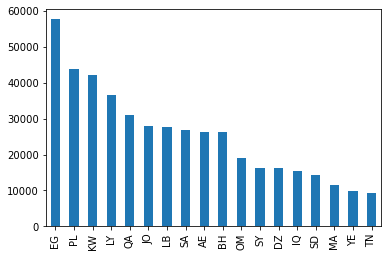

In [5]:
dialect_df['dialect'].value_counts().plot(kind='bar')

# Generate text from tweets to make data balanced

In [6]:
import tensorflow as tf
import numpy as np
import os

In [7]:
def tweets_to_text(country_code):
    return ' '.join(dialect_df[dialect_df['dialect'] == country_code]['tweet'].values)

In [8]:
tn_text = tweets_to_text('TN')

In [9]:
len(tn_text)

685763

In [10]:
tn_text[:200]

'ناس بكري قالوا طيح وشوف شكون يوقف معاك غيب وشوف شكون يسال عليك و بعد غربل و صفي مثل شعبي تونسي تونس المزيانه تهبل والله فنانه مبدعه انت ماشاء الله الله يبارك فيك يعيشك عيدكم مبروك وسنين دايمه دلوع الل'

In [11]:
tn_vocab = sorted(set(tn_text.split()))

In [12]:
char2idx = {char:index for index, char in enumerate(tn_vocab)}
idx2char = np.array(tn_vocab)

In [13]:
text_as_int = np.array([char2idx[char] for char in tn_text.split()])

In [14]:
seq_length = 3
examples_per_epoch = len(tn_text.split())//seq_length

In [15]:
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [16]:
for i in char_dataset.take(10):
    print(idx2char[i.numpy()])

ناس
بكري
قالوا
طيح
وشوف
شكون
يوقف
معاك
غيب
وشوف


In [17]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
# Try 10
for item in sequences.take(10):
    print(repr(' '.join(idx2char[item.numpy()])))

'ناس بكري قالوا طيح'
'وشوف شكون يوقف معاك'
'غيب وشوف شكون يسال'
'عليك و بعد غربل'
'و صفي مثل شعبي'
'تونسي تونس المزيانه تهبل'
'والله فنانه مبدعه انت'
'ماشاء الله الله يبارك'
'فيك يعيشك عيدكم مبروك'
'وسنين دايمه دلوع الله'


In [18]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [19]:
for input_example, target_example in  dataset.take(10):
    print ('Input data: ', repr(' '.join(idx2char[input_example.numpy()])))
    print ('Target data:', repr(' '.join(idx2char[target_example.numpy()])))

Input data:  'ناس بكري قالوا'
Target data: 'بكري قالوا طيح'
Input data:  'وشوف شكون يوقف'
Target data: 'شكون يوقف معاك'
Input data:  'غيب وشوف شكون'
Target data: 'وشوف شكون يسال'
Input data:  'عليك و بعد'
Target data: 'و بعد غربل'
Input data:  'و صفي مثل'
Target data: 'صفي مثل شعبي'
Input data:  'تونسي تونس المزيانه'
Target data: 'تونس المزيانه تهبل'
Input data:  'والله فنانه مبدعه'
Target data: 'فنانه مبدعه انت'
Input data:  'ماشاء الله الله'
Target data: 'الله الله يبارك'
Input data:  'فيك يعيشك عيدكم'
Target data: 'يعيشك عيدكم مبروك'
Input data:  'وسنين دايمه دلوع'
Target data: 'دايمه دلوع الله'


In [20]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [21]:
vocab_size = len(tn_vocab)
embedding_dim = 256
rnn_units = 256

In [22]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [23]:
model = build_model(vocab_size=vocab_size, embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=BATCH_SIZE)

In [24]:
for input_example_batch, target_example_batch in dataset.take(10):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 3, 32893) # (batch_size, sequence_length, vocab_size)
(64, 3, 32893) # (batch_size, sequence_length, vocab_size)
(64, 3, 32893) # (batch_size, sequence_length, vocab_size)
(64, 3, 32893) # (batch_size, sequence_length, vocab_size)
(64, 3, 32893) # (batch_size, sequence_length, vocab_size)
(64, 3, 32893) # (batch_size, sequence_length, vocab_size)
(64, 3, 32893) # (batch_size, sequence_length, vocab_size)
(64, 3, 32893) # (batch_size, sequence_length, vocab_size)
(64, 3, 32893) # (batch_size, sequence_length, vocab_size)
(64, 3, 32893) # (batch_size, sequence_length, vocab_size)


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           8420608   
                                                                 
 gru (GRU)                   (64, None, 256)           394752    
                                                                 
 dense (Dense)               (64, None, 32893)         8453501   
                                                                 
Total params: 17,268,861
Trainable params: 17,268,861
Non-trainable params: 0
_________________________________________________________________


In [26]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [27]:
sampled_indices

array([ 9193, 32766, 15155], dtype=int64)

In [28]:
input_example_batch[0]

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 5374, 19082, 25069])>

In [29]:
print("Input: \n", repr(" ".join(idx2char[input_example_batch[0].numpy()])))
print()
print("Next Char Predictions: \n", repr(" ".join(idx2char[sampled_indices])))

Input: 
 'المدرسيه قلت نخلط'

Next Char Predictions: 
 'بوقه يهلك سليتها'


In [30]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 3, 32893)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       10.400959


In [31]:
model.compile(optimizer='adam', loss=loss)

In [32]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True)

In [33]:
EPOCHS = 10

In [34]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
511/511 [==============================] - 20s 29ms/step - loss: 9.2139
Epoch 2/10
511/511 [==============================] - 21s 40ms/step - loss: 8.3973
Epoch 3/10
511/511 [==============================] - 20s 38ms/step - loss: 7.8905
Epoch 4/10
511/511 [==============================] - 19s 35ms/step - loss: 7.1779
Epoch 5/10
511/511 [==============================] - 19s 37ms/step - loss: 6.3635
Epoch 6/10
511/511 [==============================] - 20s 39ms/step - loss: 5.5585
Epoch 7/10
511/511 [==============================] - 20s 38ms/step - loss: 4.8250
Epoch 8/10
511/511 [==============================] - 20s 39ms/step - loss: 4.2061
Epoch 9/10
511/511 [==============================] - 18s 35ms/step - loss: 3.7141
Epoch 10/10
511/511 [==============================] - 20s 38ms/step - loss: 3.3325


In [35]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints\\ckpt_10'

In [36]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [37]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 5

    # Converting our start string to numbers (vectorizing)
    input_eval = [np.random.randint(0, len(tn_vocab))]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ' '.join(text_generated))

In [38]:
for i in range(50):
    print(generate_text(model, start_string=''))

و التبهليل و الخاله بيتفاهموا
اب فيه و تعمق في
تحيه ليك من تونس شبي
يعني فوق نشوف باكو هيك
هي الحاجه هاذي توجعك قصها
دراويش عالخبزه والمي يا باب
سبتمبر اللي بيستاهل اكثر منو
طالعه وعلي معاش خرجت السوري
فيضانات متسببه عمرها ثلاثه لغات
بنت دالي بيها سلبي ولا
كيما مستانش عادل بعض حتا
ههه حلوه ابداااع فخامه و
الخلفاوي حاله نقابه شقيقه يتعدي
الكاينات كي تمشي وينكم تعالو
الارهابيه غشوها عطوها و احنا
لخر الجهات ومن البيبان الكل
كعبه بوفريوه جمهوره مش راح
جايز ههه ما يعطينش و
يسكر لو باش نصون للقروي
كورويه السااافل خطير برشا لكن
الصبح علي الريق احكي فيك
حارقه ذكراك طول يطلع الاحوال
هي مش دول بالوجع وبرضو
يستحي ولا كل ما ينجمش
في قالك زعيم تويتر و
والبرازيل مزور بطاقته و الا
جدد التزليطه الي فيه قبل
النصر يمنشني عندك تاليفون معبي
اجبد يا طرشه هذاك ياسر
زيد اتلهي يولي اللمه الكل
و احترام فلسطين ونروحو نكته
محلاه سالمين يبوظ يضحكوني في
الاخر يعطيه وتشرفت بسكاتهم ولا
بعض الناس باخلاقوا وانا قلت
قويه برشا في النيابه العموميه
عايز عجبتكم ما جاوبنا جيبلي
في كل شيء نوحلوه في
يزيونا ومين يعطيكم الصحه م